In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [4]:
from tqdm.notebook import tqdm
from PIL import Image
import os

In [5]:
from torchinfo import summary

In [6]:
## parameters
### 五张图片一组
step=5

### read images

In [7]:
## path = r'C:\Users\liuya\Downloads\3d_printing_research\clipped_samples_otsu'
path = r'C:\Users\liuya\Downloads\3d_printing_research\clipped_samples'
image_list = os.listdir(path)

In [8]:
full_path = os.path.join(path, image_list[350])
np.array(Image.open(full_path).convert('RGB')).shape

(250, 730, 3)

In [9]:
image_ls = []

for i in tqdm(image_list):
    full_path = os.path.join(path, i)
    img = Image.open(full_path).convert('L')
    img_array = np.asarray(img)
    image_ls.append(img_array)

  0%|          | 0/4046 [00:00<?, ?it/s]

In [10]:
### normalize
data_input = np.array(image_ls)
### np.divide((data_input-np.min(data_input)), (np.max(data_input)-np.min(data_input)))

In [11]:
data_input = np.divide((data_input-np.min(data_input)), (np.max(data_input)-np.min(data_input)))

In [12]:
data_input = torch.tensor(data_input[:,None,:,:], dtype=torch.float32)

In [13]:
data_input.shape

torch.Size([4046, 1, 250, 730])

### build the model

In [14]:
class Conv_NN_encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2d1 = nn.Conv2d(1, 16, kernel_size=(10,30))
        self.maxpool2d1 = nn.MaxPool2d((3,9), return_indices=True)
        self.conv2d2 = nn.Conv2d(16, 8, kernel_size=(10,30))
        self.maxpool2d2 = nn.MaxPool2d((3,9), return_indices=True)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=920, out_features=128)
        
    def forward(self, x):
        batch_size = x.shape[0]
        n_tau = x.shape[2]
        ## 1 means 1 channel, multiply sample size with tau to create this many of 1*W vectors
        ## x = x.view((-1, 1, x.shape[3], x.shape[4]))
        output = F.relu(self.conv2d1(x))
        output, indices1 = self.maxpool2d1(output)
        output = F.relu(self.conv2d2(output))
        output, indices2 = self.maxpool2d2(output)
        output = self.flatten(output)
        output = self.linear1(output)
        #back to the previous dimension (sample_size, tau)
        #output = output.view((batch_size, n_tau, -1))
        return output, indices1, indices2

In [15]:
class Conv_NN_decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(128, 920)
        self.maxunpool2d1 = nn.MaxUnpool2d((3,9))
        ## self.conv2d1 = nn.Conv2d(8, 16, kernel_size=(10,30), padding=(9,29))
        self.conv2d1 = nn.ConvTranspose2d(8, 16, kernel_size=(10,30))
        self.maxunpool2d2 = nn.MaxUnpool2d((3,9))
        ## self.conv2d2 = nn.Conv2d(16, 1, kernel_size=(10,30), padding=(9,29))
        self.conv2d2 = nn.ConvTranspose2d(16, 1, kernel_size=(10,30))
        #self.pad = nn.ConstantPad2d((9,9,58,0), 0)

        
    def forward(self, x, indices1, indices2):
        ## x = x.contiguous().view((-1, x.shape[2]))
        output = self.linear1(x)
        output = output.view((output.shape[0], 8, -1, 5))
        output = self.maxunpool2d1(output, indices2, output_size=torch.Size([output.shape[0], 8, 71, 48]))
        output = self.conv2d1(output)
        output = self.maxunpool2d2(output, indices1, output_size=torch.Size([output.shape[0], 16, 241, 701]))
        output = self.conv2d2(output)
        #output = self.pad(output)
        #back to original size
        #output = output.view((-1, 1, 5, output.shape[2], output.shape[3]))
        return output

In [16]:
class net(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.Conv_NN_encoder = args[0]
        self.Conv_NN_decoder = args[1]
    
    def forward(self, x):
        output, indc1, indc2 = self.Conv_NN_encoder(x)
        output = self.Conv_NN_decoder(output, indc1, indc2)
        return output

In [17]:
model = net(Conv_NN_encoder(), Conv_NN_decoder())

In [18]:
summary(model,input_size=(10,1,250,730))

Layer (type:depth-idx)                   Output Shape              Param #
net                                      --                        --
├─Conv_NN_encoder: 1-1                   [10, 128]                 --
│    └─Conv2d: 2-1                       [10, 16, 241, 701]        4,816
│    └─MaxPool2d: 2-2                    [10, 16, 80, 77]          --
│    └─Conv2d: 2-3                       [10, 8, 71, 48]           38,408
│    └─MaxPool2d: 2-4                    [10, 8, 23, 5]            --
│    └─Flatten: 2-5                      [10, 920]                 --
│    └─Linear: 2-6                       [10, 128]                 117,888
├─Conv_NN_decoder: 1-2                   [10, 1, 250, 730]         --
│    └─Linear: 2-7                       [10, 920]                 118,680
│    └─MaxUnpool2d: 2-8                  [10, 8, 71, 48]           --
│    └─ConvTranspose2d: 2-9              [10, 16, 80, 77]          38,416
│    └─MaxUnpool2d: 2-10                 [10, 16, 241, 701]     

### train the model

In [19]:
def train(model, device, train_loader, optimizer, epoch):
    
    model.train() #trian model
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        ##calculate loss
        loss = 0
        for i in range(data.shape[0]):
            loss += F.mse_loss(output[i], data[i], reduction='sum')
        loss /= data.shape[0]
        #loss = F.mse_loss(output, data)
        loss.backward()
        optimizer.step()
        # print result every 10 batch
        if batch_idx % 10 == 0:
            print('Train Epoch: {} ... Batch: {} ... Loss: {:.8f}'.format(epoch, batch_idx, loss))

In [20]:
def test(model, device, test_loader):
    model.eval() #evaluate model
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data)
            #calculate sum loss
            test_loss += F.mse_loss(output, data, reduction='sum').item()
    
        test_loss /= len(test_loader.dataset)
        print('------------------- Test set: Average loss: {:.4f} ... Samples: {}'.format(test_loss, len(test_loader.dataset)))

### train and test split

In [21]:
train_window_, val_window_ = train_test_split(data_input, test_size=0.2, random_state=2022)

In [22]:
train_loader = torch.utils.data.DataLoader(train_window_, batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(val_window_, batch_size=16,shuffle=False)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [24]:
model = model.to(device)

In [58]:
optimizer = optim.Adam(model.parameters(), lr=0.000000001)

In [59]:
epochs = 5

In [60]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 ... Batch: 0 ... Loss: 2073.71020508
Train Epoch: 1 ... Batch: 10 ... Loss: 2159.55957031
Train Epoch: 1 ... Batch: 20 ... Loss: 2168.56494141
Train Epoch: 1 ... Batch: 30 ... Loss: 1985.68896484
Train Epoch: 1 ... Batch: 40 ... Loss: 1967.27819824
Train Epoch: 1 ... Batch: 50 ... Loss: 2015.08251953
Train Epoch: 1 ... Batch: 60 ... Loss: 2068.00488281
Train Epoch: 1 ... Batch: 70 ... Loss: 2153.30834961
Train Epoch: 1 ... Batch: 80 ... Loss: 1931.04284668
Train Epoch: 1 ... Batch: 90 ... Loss: 1911.37756348
Train Epoch: 1 ... Batch: 100 ... Loss: 2018.67004395
Train Epoch: 1 ... Batch: 110 ... Loss: 1887.96435547
Train Epoch: 1 ... Batch: 120 ... Loss: 2038.35485840
Train Epoch: 1 ... Batch: 130 ... Loss: 2293.45385742
Train Epoch: 1 ... Batch: 140 ... Loss: 2098.67822266
Train Epoch: 1 ... Batch: 150 ... Loss: 2057.14721680
Train Epoch: 1 ... Batch: 160 ... Loss: 2078.20654297
Train Epoch: 1 ... Batch: 170 ... Loss: 2262.90893555
Train Epoch: 1 ... Batch: 180 ... Loss:

In [62]:
## old 3846104064
## new 389223789
## new2 5500
## new3 2000

### test the result

In [63]:
data_input[0].shape

torch.Size([1, 250, 730])

In [64]:
model.eval() #evaluate model
with torch.no_grad():
    data = data_input[350]
    data = data[None,:,:,:]
    data = data.to(device)
    output = model(data)
    output = output.cpu()

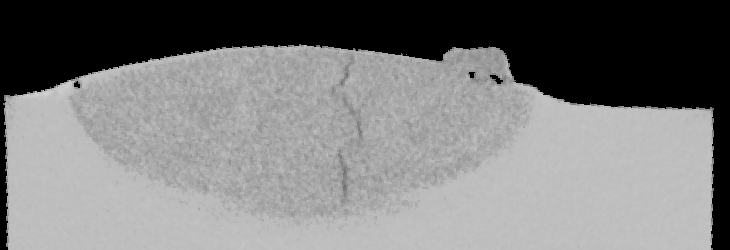

In [65]:
## cut the image
original = data_input[350,0].numpy()*255
Image.fromarray(original.astype('uint8'), 'L')

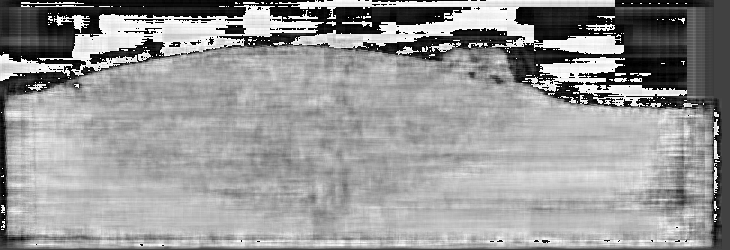

In [66]:
predict = output[0,0].numpy()*255
Image.fromarray(predict.astype('uint8'), 'L')

In [40]:
## Image.fromarray(output[0,0].numpy().astype('uint8'), 'L')